In [36]:
import tools
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols
from scipy.optimize import fsolve
import seaborn as sns
import numpy as np
from lmfit import Parameters, fit_report, minimize
!jupyter nbconvert --to script outage_bunching.ipynb 
# converts notebook to py file needed to import results from bunching
from outage_bunching import bunch60, bunch120


np.random.seed(111)

[NbConvertApp] Converting notebook outage_bunching.ipynb to script
[NbConvertApp] Writing 8683 bytes to outage_bunching.py


In [26]:
dx60 = bunch60.total_bunch()
dx120 = bunch120.total_bunch()
print(dx60, dx120)

4.303755439887405 1.0355002865033742


In [27]:
wd = Path.cwd()
data = pd.read_csv(wd.parent/'data'/'data_transformed'/'outage_bunch.csv')

data.head()

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,division_name,id,area_affected,noofcustomersaffected,capacity,duration,unservedmuduetooutage,remarks,date,end_date,...,dairy,residential,minute_of_day,q,quarter,hourly,year,r_permin,pi,duration_cf
0,alaknanda,1.0,"part off dsidc okhla phase‐1,",312.0,other outage,0:43,0.000005,outage due to\nfault,2019-12-02 00:00:00,2019-12-02 00:00:00,...,0.0,0.0,31.0,3.0,49898.0,16993.0,2019.0,0.116279,0.930233,43.0
1,alaknanda,2.0,"part off indira kalyan vihar okhla phase‐1,",314.0,other outage,0:09,0.000017,outage due to\nfault,2019-12-03 00:00:00,2019-12-03 00:00:00,...,0.0,0.0,30.0,3.0,49924.0,17003.0,2019.0,1.888889,15.111111,9.0
2,alaknanda,3.0,"part off b‐block kalka ji,e‐block kalka ji,f‐b...",303.0,other outage,0:57,0.000633,outage due to fault,2019-12-05 00:00:00,2019-12-05 00:00:00,...,0.0,0.0,19.0,2.0,50008.0,17036.0,2019.0,11.105263,88.842105,57.0
3,alaknanda,4.0,"part off railway yard,",302.0,other outage,0:37,0.000319,outage due to\nfault,2019-12-06 00:00:00,2019-12-06 00:00:00,...,0.0,0.0,21.0,2.0,50072.0,17060.0,2019.0,8.621622,68.972973,37.0
4,alaknanda,5.0,"part off cng station okhla phase‐1,a‐block okh...",140.0,other outage,0:33,0.000413,outage due to fault,2019-12-06 00:00:00,2019-12-06 00:00:00,...,0.0,0.0,30.0,3.0,50063.0,17057.0,2019.0,12.515152,100.121212,33.0


$\pi$: revenue loss from outage

Calculation: \
$r =$ unserved kWh / duration of outage \
$\pi = r * tariff$

unserved kWh is a function of the number of customers affected and the duration of the outage

median pi: 44.44444444444444
0.8333333333333334 1.6666666666666667


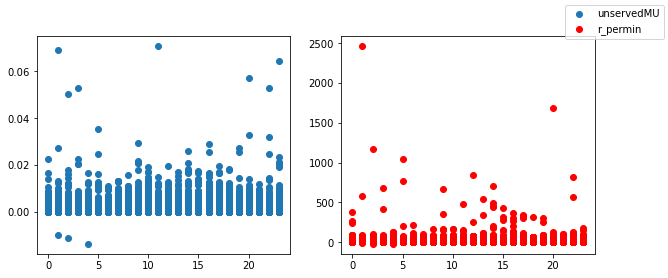

In [6]:
## calculate pi 

#the tariff is a price per kwh
tariff = 8

data['r_permin'] = data.apply(lambda row: row.unservedmuduetooutage * 1e6 / row.duration_minutes, axis = 1)

data['pi'] = data.r_permin * tariff

pi = data.pi.median()

print('median pi:', pi)



# define parameters 
phi = 50/60 
phi120 = 100/60
print(phi, phi120)

#sns.kdeplot(data.r_permin)

# 
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(data.hour_of_day, data.unservedmuduetooutage, label = 'unservedMU')
ax[1].scatter(data.hour_of_day, data.r_permin, label='r_permin', color='red')
fig.legend()

#data.r_permin.describe()

## model estimation : alpha

non-linear least squares

$ (\frac{\pi + \phi}{\pi}) (\frac{x}{x + \Delta x}) = \frac{1}{\alpha} [(\frac{\pi + \phi}{\phi})^{\alpha / 1+\alpha} (1+\alpha) - (1 + \frac{\Delta x}{x})^{\alpha}]$

In [149]:
# code source: https://lmfit.github.io/lmfit-py/fitting.html

data_clean = data[data.pi >0] # keep only non-negative values
# calculate left side of equation
left = data_clean.apply(lambda row: (row.pi + phi) / row.pi * 60/(60+dx60) , axis = 1 ).to_numpy()

pars = Parameters()
pars.add('alpha', value = .8)

def residual(pars,pi, data ,phi = phi, x = 60, dx = dx60):
    vals = pars.valuesdict()
    alpha = vals['alpha']
    # RHS of equation
    model = 1/alpha * (((pi + phi)/phi)**(alpha /(1+alpha)) * (1+alpha) - (1 + (dx/ x))**alpha )
    return model - data

fit_params = Parameters()
fit_params.add('alpha', value = .5)

# fit model
out = minimize(residual, fit_params, args = (data_clean.pi.to_numpy() ,left))
print(fit_report(out)) # output

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 87690
    # variables        = 1
    chi-square         = 9311.39608
    reduced chi-square = 0.10618659
    Akaike info crit   = -196648.861
    Bayesian info crit = -196639.479
[[Variables]]
    alpha: -0.94022612 +/- 9.7503e-04 (0.10%) (init = 0.5)


In [168]:
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')


-------------------------------
Parameter    Value       Stderr
alpha      -0.94023     0.00098


In [169]:
alpha = out.params['alpha'].value



solve for $\alpha$ and compare: $K(x^I) = K(x^*)$

$K(x^I) = (\pi + \phi)^{\alpha /1+\alpha} (x^* + \Delta x^*) \pi^{1/1+\alpha}  (1 + 1/\alpha)$


at $x$ around $60$: $\phi = 50$

If $x>120$: $\phi = 100$


I am now doing it for N=1, not sure if that's right. Also, we should double check the functions. What values of $\pi$ and $\phi$ should we use? For $\pi$ we could maybe do a weighted average

alpha: 5.925371436624084 deltax 4.303755439887405
alpha: 5.283274454191148 deltax 1.0355002865033742


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  first = sigma / alpha
<ipython-input-28-9f8946c7dab8>:25: RuntimeWarning: invalid value encountered in double_scalars
  return L(a) - R(a)


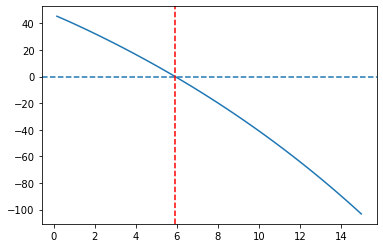

In [28]:
alpha60 = tools.solve_alpha(60, bunch60.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue = 10)
alpha120 = tools.solve_alpha(120, bunch120.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue=10)

print('alpha:',alpha60, 'deltax', bunch60.total_bunch())
print('alpha:',alpha120, 'deltax', bunch120.total_bunch())

alpha = alpha60
#alpha = 0.8

# plot indifference as a function of alpha
delta_x = bunch60.total_bunch()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+50/60)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=50/60, phi120 = 100/60,alpha=a, N=1)
    
def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)

alphas = np.linspace(0,15, 100)
sol =  [solution(a) for a in alphas]
plt.plot(alphas,sol)
plt.axhline(0, linestyle = 'dashed')
plt.axvline(alpha60, linestyle='dashed', color = 'red')

## calculate the $\sigma$'s based on the counterfactual x's and alpha's

In [ ]:
data['sigma'] = 0

def get_sigma(s,x):
    if x < 60:
        exp = tools.xopt(s, pi = pi, phi=0, alpha = 1.5, N=N) - x
    elif x < 120:
        exp = tools.xopt(s, pi = pi, phi=50/60, alpha = 1.5, N=N) - x
    else:   
        exp = tools.xopt(s, pi = pi, phi=100/60, alpha = 1.5, N=N) - x
    return exp

for i in data.index:
    s = symbols('s')
    x = data.loc[i, 'duration_cf']
    N = data.loc[i, 'noofcustomersaffected']
    pi = data.loc[i, 'pi']
    data.loc[i,'sigma'] = fsolve(get_sigma, x0 = 10, args = (x))[0]


In [ ]:
sns.kdeplot(x =data.sigma)
plt.xlim(-1000,20000)
data.sigma.describe()
# we have some missing values, in don't know why because all inputs seem to have no missings
# but maybe this explains the strange density